In [1]:
!pip install array_to_latex


In [33]:
import sys
import numpy as np
from numpy import cos,sin,pi,arctan2,sqrt
import array_to_latex as art
np.set_printoptions(precision=3,suppress=True)
from IPython.display import Latex,display_latex



In [34]:
Latex(r"""""")

<IPython.core.display.Latex object>

In [35]:
class Transform:
  def __init__(self,array=np.identity(4)):
    self.transform = array

  def __mul__(self, other):
    return Transform(self.transform @ other.transform)
  
  def __str__(self):
    return str(self.transform)


  def latex(self):
    if 'array_to_latex' not in sys.modules:  
      return str(self.transform)
    else :
      #Latex(art.to_ltx(self.transform, print_out=False))
      display_latex(art.to_ltx(self.transform, print_out=False),raw=True)


  def ComputeAngles(self):
    return np.array([
     arctan2(self.transform[2][1],self.transform[2][2]),
     arctan2(-self.transform[2][0],sqrt(self.transform[2][1]**2 +self.transform[2][2]**2 )),
     arctan2(self.transform[1][0],self.transform[0][0])
    ])
  def inverse(self):
    t = self.transform[:3,:3]
    inv = np.identity(4)
    inv[:3,:3]=t.T
    inv[:,3]=t.T @ (-self.transform[:,3])
    return Transform(inv)

In [36]:
class Joint:
    def CalculateTransform(self):
        self.transform=Transform( np.array( [
            [cos(self.theta),-1*sin(self.theta)*cos(self.alpha),sin(self.theta)*sin(self.alpha),self.a*cos(self.theta)],
            [sin(self.theta),cos(self.theta)*cos(self.alpha),-1*cos(self.theta)*sin(self.alpha),self.a*sin(self.theta)],
            [0,sin(self.alpha),cos(self.alpha),self.d],
            [0,0,0,1]
            ]))
    def ShowParameters(self):
      print("a : ",self.a," , ")
      print("alpha : ",self.alpha," , ")
      print("d : ",self.d," , ")
      print("theta : ",self.theta," , ")
      print("type : ",self.jtype)
      print(" | \n ")
  

In [37]:
class PrismaticJoint (Joint) :
  def __init__(self,alpha,a,theta):
    self.transform = Transform (np.identity(4))
    self.alpha = alpha * (pi/180)
    self.a = a
    self.theta = theta * (pi/180)
    self.jtype = "Prismatic"

  def GetTransform(self,d):
    self.d= d
    self.CalculateTransform()
    return self.transform


In [38]:
class RevolveJoint (Joint):
  def __init__(self,alpha,a,d):
    self.transform = Transform (np.identity(4))
    self.alpha = alpha * (pi/180)
    self.a = a
    self.d = d
    self.jtype = "Revolve"
  
  def GetTransform(self,theta):
    self.theta = theta*(np.pi/180)
    self.CalculateTransform()
    return self.transform

In [39]:
class ForwardKinematics :
  def __init__(self,DH_table):
    self.__Result=1
    self.__maxlength = 0
    self.transforms = []
    for t in DH_table:
      self.AddTransform(t['type'],t['a'],t['alpha'],t['d'],t['theta'])

  def ShowDH (self):
    print("number,a,alpha,d,theta")
    for t in range(len(self.transforms)):
      print( t , " : ")
      self.transforms[t].ShowParameters()

  def AddTransform (self,jtype,a,alpha,d,theta):
    if jtype =='prismatic':
      self.transforms.append(PrismaticJoint(alpha,a,theta))
    elif jtype =='revolve':
      self.transforms.append(RevolveJoint(alpha,a,d))
    else :
      raise AssertionError("Invalid joint type")

  def RemoveTransform(self,i):
    del self.transforms[i]

  def Compute(self,angles):
    if len(angles)!= len(self.transforms):
      raise AssertionError("the angles is not equal to transforms")
    self.__Result = Transform()
    for t in range (len(self.transforms)):
      self.__Result =self.transforms[len(self.transforms)-1-t].GetTransform(angles[len(self.transforms)-1-t]) * self.__Result

    return self.__Result



In [40]:
#define links dimentions

l1 =1
l2 =1
l3 =1
l4 =1

#define D-H table parameters
dh =  [
    {'alpha': 90, 'a': 0,   'theta': 0, 'd': l1,  'type': 'revolve'},
    {'alpha': 0,  'a': l2,  'theta': 0, 'd': 0,   'type': 'revolve'},
    {'alpha': 0,  'a': l3,  'theta': 0, 'd': 0,   'type': 'revolve'},
    {'alpha': 0,  'a': l4,  'theta': 0, 'd': 0,   'type': 'revolve'},
      ]

kc=ForwardKinematics(dh)

In [65]:
res = kc.Compute([90,0,0,0])
print(res)

[[ 0. -0.  1.  0.]
 [ 1.  0. -0.  3.]
 [ 0.  1.  0.  1.]
 [ 0.  0.  0.  1.]]


In [42]:
res.latex()

In [43]:
def CreateDataPoints(X,Y,Kinematics,angles,DoF,Step,Offset,Resolution):
  for i in range(Resolution):
    if DoF==1 :
      x = Kinematics.Compute(angles)
      X.append(x)
      Y.append(angles[:4].copy())      
    else :
      X,Y= CreateDataPoints(X,Y,Kinematics,angles,DoF-1,Step,Offset,Resolution)
    angles[-(DoF-1)] = Offset[-(DoF-1)] + (i+1) * Step[-(DoF-1)]
  return X,Y


In [44]:
def CreateNewDataset(DoF,Resolution,Kinematics,Range):
  X = []
  Y=[]
  step = (Range[:,1]-Range[:,0])/Resolution
  offset = Range[:,0]
  angles = np.zeros(DoF)

  X,Y = CreateDataPoints(X,Y,Kinematics,angles,DoF,step,offset,Resolution)

  return np.array(X),np.array(Y)

In [15]:
ranges = np.array([[0,90],[-90,90],[-90,0],[-90,0]])
X,Y=CreateNewDataset(4,30,kc,ranges)
print(X.shape)

(810000,)


In [45]:
#print(X.transform[:3,3])
type(X)
print(X.shape)

(810000,)


In [57]:
print(X)

 <__main__.Transform object at 0x000002589A716970> ...


In [46]:
def SaveToCSV(X,Y,SavePath):
    data = np.column_stack((X.transform[:3,3],Y))
    np.savetxt(SavePath, data,fmt='%1.3f', delimiter=',')


In [47]:
SaveToCSV(X,Y,"file.csv")

AttributeError: 'numpy.ndarray' object has no attribute 'transform'

In [48]:
X

array([<__main__.Transform object at 0x000002589A716850>,
       <__main__.Transform object at 0x00000258FF8926A0>, ...,
       <__main__.Transform object at 0x00000258B97AE310>], dtype=object)

In [49]:
Y

array([[ 0.,  0.,  0.,  0.],
       [ 3.,  0.,  0.,  0.],
       [ 6.,  0.,  0.,  0.],
       ...,
       [81., 84., -3., -3.],
       [84., 84., -3., -3.],
       [87., 84., -3., -3.]])

# Visualization of dataset points 

In [50]:
pip install pyntcloud


Note: you may need to restart the kernel to use updated packages.


In [51]:
from pyntcloud import PyntCloud
import pandas as pd


In [62]:

df = pd.DataFrame([x.transform[:3,3] for x in X], columns = ['x','y','z'])
pntc=PyntCloud(df)
df.head(10)

,x,y,z
0,2.995889,0.157008,1.0
1,2.983566,0.313585,1.0
2,2.963065,0.469303,1.0
3,2.934443,0.623735,1.0
4,2.897777,0.776457,1.0
5,2.853170,0.927051,1.0
6,2.800741,1.075104,1.0
7,2.740636,1.220210,1.0
8,2.673020,1.361971,1.0
9,2.598076,1.500000,1.0


In [64]:
df =pd.DataFrame([y for y in Y])
df.head(2)

,0,1,2,3
0,3.0,0.0,0.0,0.0
1,6.0,0.0,0.0,0.0


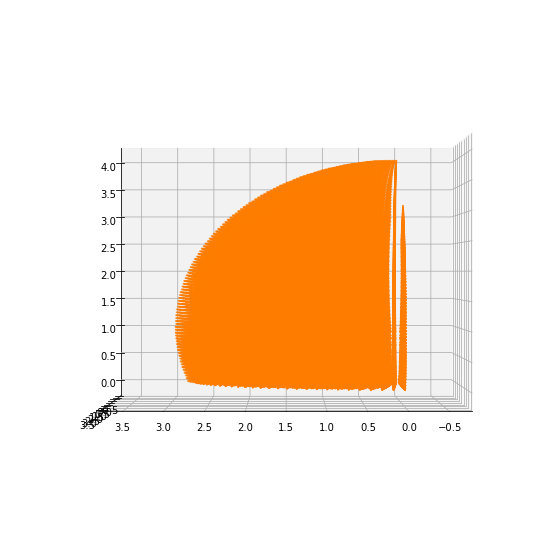

In [60]:
pntc.plot(return_scene=True,colors='blue', edgecolors='red')
#facecolors='none', edgecolors='red'

# Seperate points of the first quarter

we have to seperate the points in the positive side of x,y and z from the whole data points 

In [54]:
def FirstQuarterPoints(X,Y):
  x = []
  y = []
  for i in range (len(X)):
    
    if (X[i].transform[:3,3])[0]>0 and (X[i].transform[:3,3])[1]>0 and (X[i].transform[:3,3])[2]>0:
      x.append(X[i])
      y.append(Y[i])
  return np.array(x),np.array(y)



In [55]:
X,Y=FirstQuarterPoints(X,Y)
print(X.shape)

(318536,)


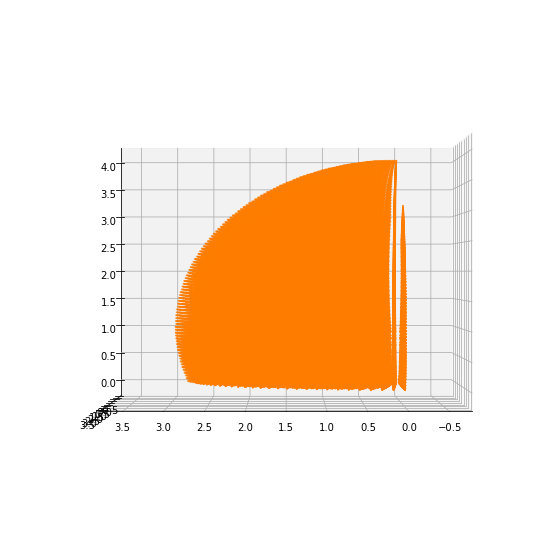

In [56]:

df = pd.DataFrame([x.transform[:3,3] for x in X], columns = ['x','y','z'])
pntc=PyntCloud(df)
pntc.plot(return_scene=True)

# determining unreachable point's condition

we can notice initially that the reachable point's is the sphere that has the center $(0,0,l_1)$ and the radius $l_2 + l_3 + l_4$

so, for any given point, this condition should be satisfied : 

$ x^2 + y^2 + (z - l_1)^2 <= (l_2+ l_3 + l_4 - l_1)^2 $

the problem will be more complicated if we consider that every actiuator has limited range of angles, but for simlicity, we will keep this assumption valid.

In [32]:

def InRange(p):
  if p[2]<0:
    return False
  r2 = p[0]**2 + p[1]**2 + (p[2]-l1)**2 
  if r2<= (l2 + l3 + l4 - l1)**2 :
    return True
  else :
    return False

# Clustering dataset points

as we might think : there must be more than one configuration for the same point, this will disturb the model and brevent it from reaching global minima, so we need to make sure that our dataset has only one angles configuration for each point in space.

first, we will create clustering centers, which is points with specified resolution in the first quarter, then every point in dataset will be clustered according to the closest center.

we will use **KNeighborsClassifier** from **sklearn**

In [33]:
dl = 0.05

knnPoints = []
for i in range(int((l1+l2+l3+l4)/dl) +1):
  for j in range(int((l1+l2+l3+l4)/dl) +1):
    for k in range(int((l1+l2+l3+l4)/dl) +1):
      p= [i*dl,j*dl,k*dl]
      if InRange(p):
        knnPoints.append(p)

knnIndeces = [i for i in range(len(knnPoints))]


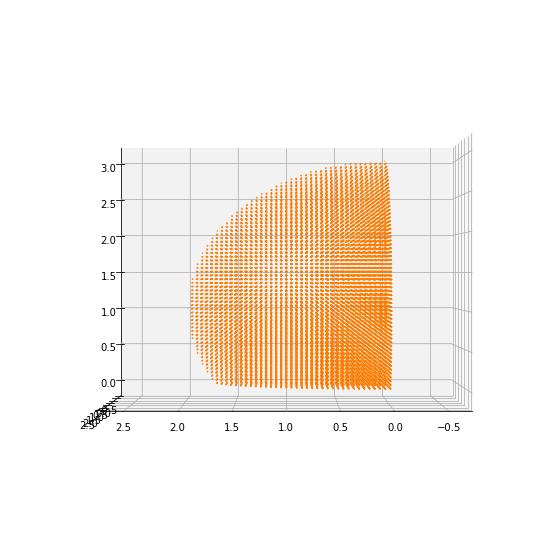

In [34]:
from pyntcloud import PyntCloud
import pandas as pd
df = pd.DataFrame(knnPoints, columns = ['x','y','z'])
pntc=PyntCloud(df)
pntc.plot(return_scene=True)

In [35]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np


nbrs = KNeighborsClassifier(n_neighbors=1)
nbrs.fit(knnPoints,knnIndeces)


KNeighborsClassifier(n_neighbors=1)

In [36]:
sortedPoints = {}
for i in range(len(knnPoints)):
  sortedPoints[str(i)] = {'x':[],'y':[]}

In [37]:

for i in range(len(X)):
  pred = nbrs.predict([X[i].transform[:3,3]])
  sortedPoints[str(pred[0])]['x'].append(X[i])
  sortedPoints[str(pred[0])]['y'].append(Y[i])

for now, we will choose the point with the minimum Euler x angle

In [ ]:
X_train =[]
Y_train = []
for i in range(len(knnPoints)):
  if len(sortedPoints[str(i)]['x'])!=0:
    if len(sortedPoints[str(i)]['x']) ==1 :
      X_train.append(sortedPoints[str(i)]['x'][0].transform[:3,3].tolist())
      Y_train.append(sortedPoints[str(i)]['y'][0])
    else :
      angles = [sortedPoints[str(i)]['x'][k].ComputeAngles()[0] for k in range(len(sortedPoints[str(i)]['x']))]
      minIndex = angles.index(min(angles))
      X_train.append(sortedPoints[str(i)]['x'][minIndex].transform[:3,3].tolist())
      Y_train.append(sortedPoints[str(i)]['y'][minIndex].tolist())

X_train =np.array(X_train)
Y_train = np.array(Y_train)

# Normalizing data-set

now we normalize angles in the selected ranges, and position to the maximum possible range 


In [ ]:
def NormalizeData (Xdata,Ydata,PMax,Ranges):
  Xdata = Xdata[:]/PMax
  offset = Ranges[:,0]
  width = Ranges[:,1]-Ranges[:,0]
  for i in range(len(Ydata)):
    Ydata[i] = (Ydata[i]-offset)/width
  return Xdata,Ydata
    

In [ ]:

X,Y = NormalizeData(X_train,Y_train,l1+l2+l3+l4,ranges)

In [ ]:
print(X)

[[0.078 0.004 0.996]
 [0.005 0.091 0.994]
 [0.006 0.117 0.989]
 ...
 [0.737 0.117 0.276]
 [0.73  0.155 0.328]
 [0.749 0.039 0.25 ]]


In [ ]:
print(Y)

[[0.033 0.967 1.    1.   ]
 [0.967 0.967 1.    0.967]
 [0.967 0.967 1.    0.9  ]
 ...
 [0.1   0.533 1.    0.867]
 [0.133 0.533 1.    1.   ]
 [0.033 0.5   1.    1.   ]]


# Creating deep learning model 

In [ ]:
from tensorflow.python.keras.backend import dropout

import tensorflow 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.optimizers import Adam

# Configuration options
feature_vector_length = 3
num_classes = 4

X_train =np.array(X) 
Y_train = np.array(Y)

# Set the input shape
input_shape = (feature_vector_length,)

# Create the model
model = Sequential()
model.add(Dense(50, input_shape=input_shape, activation='relu'))
model.add(Dropout(rate=0.4))
model.add(Dense(50, activation='relu'))
model.add(Dropout(rate=0.4))
model.add(Dense(num_classes, activation='relu'))

# Configure the model and start training

model.compile(loss='mean_squared_error', metrics=['accuracy'], optimizer=Adam(learning_rate=1e-3))
history =model.fit(X, Y, epochs=3000, batch_size=100, verbose=1, validation_split=0.1,shuffle=True)



Streaming output truncated to the last 5000 lines.
174/174 [==============================] - 0s 2ms/step - loss: 0.0068 - accuracy: 0.8929 - val_loss: 0.0111 - val_accuracy: 0.8888
Epoch 502/3000
174/174 [==============================] - 0s 2ms/step - loss: 0.0069 - accuracy: 0.8917 - val_loss: 0.0107 - val_accuracy: 0.8894
Epoch 503/3000
174/174 [==============================] - 0s 2ms/step - loss: 0.0069 - accuracy: 0.8906 - val_loss: 0.0124 - val_accuracy: 0.8868
Epoch 504/3000
174/174 [==============================] - 0s 2ms/step - loss: 0.0067 - accuracy: 0.8898 - val_loss: 0.0113 - val_accuracy: 0.8888
Epoch 505/3000
174/174 [==============================] - 0s 2ms/step - loss: 0.0068 - accuracy: 0.8872 - val_loss: 0.0119 - val_accuracy: 0.8873
Epoch 506/3000
174/174 [==============================] - 0s 2ms/step - loss: 0.0068 - accuracy: 0.8887 - val_loss: 0.0103 - val_accuracy: 0.8899
Epoch 507/3000
174/174 [==============================] - 0s 2ms/step - loss: 0.0068 - a

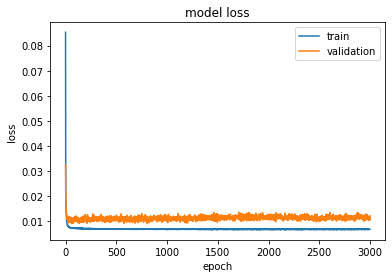

In [ ]:
import matplotlib.pyplot as plt
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()


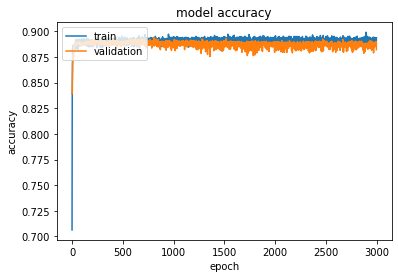

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# Test the model after training
test_results = model.evaluate(X, Y, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}%')

602/602 [==============================] - 1s 1ms/step - loss: 0.0047 - accuracy: 0.9213
Test results - Loss: 0.004701337311416864 - Accuracy: 0.9213302135467529%
